# Regularization Techniques: Ridge, Lasso, and Elastic Net

This notebook is a complete, hands-on guide to linear-model regularization.  
You'll find:
- The math intuition and objective functions
- Bayesian interpretations (MAP connections)
- Coordinate Descent update intuition
- End-to-end implementations with `scikit-learn`
- Practical guidance on scaling, hyperparameters, and model selection
- Visualizations: coefficient paths, cross-validated error vs. $\alpha$, and bias–variance style diagnostics

## Prerequisites

- Python 3.x
- `numpy`, `pandas`, `matplotlib`, `scikit-learn`

If you run into missing packages, install them (e.g., `pip install scikit-learn pandas matplotlib numpy`).

## 1) Problem setup

We consider a supervised regression problem with training data $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$ where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$.  
Let $X \in \mathbb{R}^{n \times d}$ be the design matrix and $\mathbf{y} \in \mathbb{R}^{n}$ the target vector.

The ordinary least squares (OLS) objective is:

$$
\min_{\boldsymbol{\beta}\in\mathbb{R}^d}\; \frac{1}{2n}\,\| \mathbf{y} - X\boldsymbol{\beta} \|_2^2.
$$

Regularization augments this with a penalty $\Omega(\boldsymbol{\beta})$ to control model complexity and improve generalization, especially under multicollinearity or $d \gg n$.

## 2) Ridge Regression (L2)

**Objective:**

$$
\min_{\boldsymbol{\beta}} \;\; \frac{1}{2n}\,\| \mathbf{y} - X\boldsymbol{\beta} \|_2^2 \;+\; \alpha \|\boldsymbol{\beta}\|_2^2.
$$

**Closed form solution** (when $X^\top X + 2n\alpha I$ is invertible):

$$
\hat{\boldsymbol{\beta}}_{\text{ridge}} = \left(X^\top X + 2n\alpha I\right)^{-1} X^\top \mathbf{y}.
$$

**Bayesian view:** Ridge is the **MAP** estimator under a zero-mean Gaussian prior on coefficients:

$$
\boldsymbol{\beta} \sim \mathcal{N}\!\left( \mathbf{0}, \;\tau^2 I \right), \quad \text{with } \alpha \propto \frac{1}{\tau^2}.
$$

**Notes:**
- Shrinks coefficients smoothly toward zero but typically **does not** set them exactly to zero.
- Good when features are many and correlated (stabilizes estimates).

## 3) Lasso (L1)

**Objective:**

$$
\min_{\boldsymbol{\beta}} \;\; \frac{1}{2n}\,\| \mathbf{y} - X\boldsymbol{\beta} \|_2^2 \;+\; \alpha \|\boldsymbol{\beta}\|_1.
$$

**Key property:** L1 penalty induces **sparsity** in $\hat{\boldsymbol{\beta}}$ (feature selection).

**Bayesian view:** Lasso is MAP under a zero-mean **Laplace** (double-exponential) prior:

$$
p(\beta_j) \propto \exp\!\left(-\frac{|\beta_j|}{b}\right), \quad \text{with } \alpha \propto \frac{1}{b}.
$$

**Optimization intuition (Coordinate Descent soft-thresholding):**
For a standardized design, a coordinate update has the form (scalar intuition):

$$
\beta_j \leftarrow \frac{1}{\|X_{\cdot j}\|_2^2/n}\, \mathcal{S}\!\Big( \frac{1}{n} X_{\cdot j}^\top r_{-j},\; \alpha \Big),
$$

where $\mathcal{S}(z,\lambda)=\mathrm{sign}(z)\,\max(|z|-\lambda,0)$ is the **soft-thresholding** operator and $r_{-j}$ is the partial residual.

## 4) Elastic Net (L1 + L2)

**Objective:**

$$
\min_{\boldsymbol{\beta}} \;\; \frac{1}{2n}\,\| \mathbf{y} - X\boldsymbol{\beta} \|_2^2 \;+\; \alpha\Big( \rho \|\boldsymbol{\beta}\|_1 \;+\; \tfrac{1}{2}(1-\rho) \|\boldsymbol{\beta}\|_2^2 \Big),
$$

where $\alpha \ge 0$ controls overall regularization and $\rho \in [0,1]$ trades L1 vs. L2.  
- $\rho=1$ $\Rightarrow$ Lasso  
- $\rho=0$ $\Rightarrow$ Ridge (up to scaling)

**Why EN?** When features are strongly correlated, Elastic Net tends to keep **groups** of correlated features, combining sparsity (L1) and stability (L2).

## 5) Always scale features

Because penalties act directly on coefficients, **feature scaling** matters.  
Standard practice is to standardize features (zero mean, unit variance) **inside** a pipeline so that cross-validation includes the scaler in the workflow.

## 6) Bias–Variance intuition

As $\alpha$ increases:
- Variance $\downarrow$ (coefficients shrink, model simpler)
- Bias $\uparrow$ (underfitting risk)

Choose $\alpha$ by cross-validation to balance this tradeoff.

In [1]:
# 7) Imports and synthetic dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

# Create a regression dataset with noise and correlated features via polynomial expansion
X, y = make_regression(
    n_samples=600,
    n_features=8,
    n_informative=5,
    noise=25.0,
    random_state=42
)

# Add polynomial features (degree 2) to induce multicollinearity
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

X.shape, X_poly.shape

((600, 8), (600, 44))

In [2]:
def cv_rmse(model, X, y, cv=5):
    """Return cross-validated RMSE (negative MSE -> RMSE)."""
    import numpy as _np
    from sklearn.model_selection import cross_val_score as _cvs
    scores = _cvs(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    return _np.sqrt(-scores).mean()

## 8) Baseline: OLS (no regularization)

We fit OLS in a pipeline with scaling (scaling doesn't affect OLS predictions but keeps procedures consistent).

In [4]:
ols = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("reg", LinearRegression())
])

ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols   = r2_score(y_test, y_pred_ols)
cv_ols   = cv_rmse(ols, X_train, y_train, cv=5)

print("OLS Test RMSE:", rmse_ols)
print("OLS Test R^2 :", r2_ols)
print("OLS CV RMSE  :", cv_ols)

OLS Test RMSE: 26.18175585051946
OLS Test R^2 : 0.955043359654129
OLS CV RMSE  : 26.466281473680795


## 9) Ridge: cross-validated sweep over $\alpha$

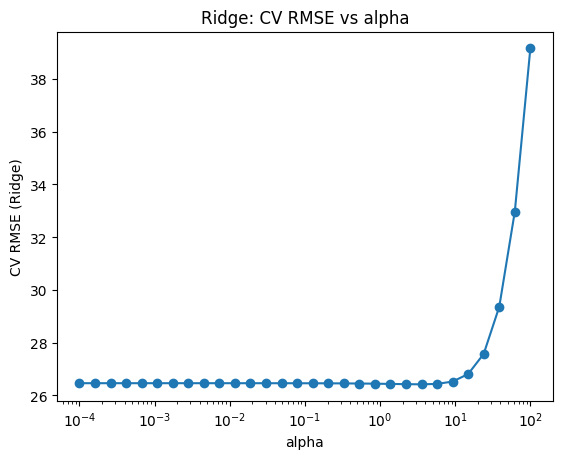

np.float64(3.562247890262444)

In [5]:
alphas = np.logspace(-4, 2, 30)
ridge_cv_rmse = []
for a in alphas:
    ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Ridge(alpha=a, random_state=42))
    ])
    ridge_cv_rmse.append(cv_rmse(ridge, X_train, y_train, cv=5))

plt.figure()
plt.semilogx(alphas, ridge_cv_rmse, marker="o")
plt.xlabel("alpha")
plt.ylabel("CV RMSE (Ridge)")
plt.title("Ridge: CV RMSE vs alpha")
plt.show()

best_alpha_ridge = alphas[int(np.argmin(ridge_cv_rmse))]
best_alpha_ridge

In [7]:
ridge_best = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=best_alpha_ridge, random_state=42))
])
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge   = r2_score(y_test, y_pred_ridge)

print("Best alpha (Ridge):", best_alpha_ridge)
print("Ridge Test RMSE   :", rmse_ridge)
print("Ridge Test R^2    :", r2_ridge)

Best alpha (Ridge): 3.562247890262444
Ridge Test RMSE   : 26.131917800254726
Ridge Test R^2    : 0.9552143503870075


## 10) Lasso: cross-validated sweep over $\alpha$

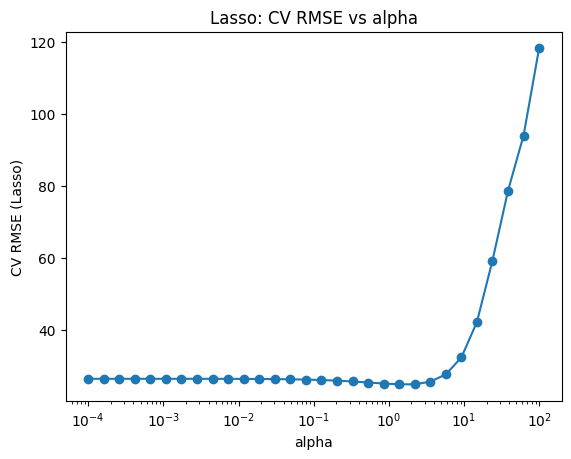

np.float64(1.3738237958832638)

In [8]:
lasso_cv_rmse = []
for a in alphas:
    lasso = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Lasso(alpha=a, max_iter=10000, random_state=42))
    ])
    lasso_cv_rmse.append(cv_rmse(lasso, X_train, y_train, cv=5))

plt.figure()
plt.semilogx(alphas, lasso_cv_rmse, marker="o")
plt.xlabel("alpha")
plt.ylabel("CV RMSE (Lasso)")
plt.title("Lasso: CV RMSE vs alpha")
plt.show()

best_alpha_lasso = alphas[int(np.argmin(lasso_cv_rmse))]
best_alpha_lasso

In [10]:
lasso_best = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Lasso(alpha=best_alpha_lasso, max_iter=10000, random_state=42))
])
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso   = r2_score(y_test, y_pred_lasso)

print("Best alpha (Lasso):", best_alpha_lasso)
print("Lasso Test RMSE   :", rmse_lasso)
print("Lasso Test R^2    :", r2_lasso)

Best alpha (Lasso): 1.3738237958832638
Lasso Test RMSE   : 25.347194774805498
Lasso Test R^2    : 0.9578637273689112


## 11) Elastic Net: grid over $(\alpha, \rho)$

We scan $\alpha$ and the mixing parameter $\rho \in [0,1]$:

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

rhos = np.linspace(0.0, 1.0, 11)
en_results = []  # (alpha, rho, cv_rmse)
for a in alphas:
    for r in rhos:
        en = Pipeline([
            ("scaler", StandardScaler()),
            ("reg", ElasticNet(alpha=a, l1_ratio=r, max_iter=10000, random_state=42))
        ])
        en_results.append((a, r, cv_rmse(en, X_train, y_train, cv=5)))

import pandas as pd
en_df = pd.DataFrame(en_results, columns=["alpha", "rho", "cv_rmse"])

# find best
idx_best = en_df["cv_rmse"].idxmin()
best_alpha_en = en_df.loc[idx_best, "alpha"]
best_rho_en   = en_df.loc[idx_best, "rho"]
(best_alpha_en, best_rho_en, en_df.loc[idx_best, "cv_rmse"])

(np.float64(1.3738237958832638),
 np.float64(1.0),
 np.float64(24.925285089195512))

In [15]:
en_best = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNet(alpha=best_alpha_en, l1_ratio=best_rho_en, max_iter=10000, random_state=42))
])
en_best.fit(X_train, y_train)
y_pred_en = en_best.predict(X_test)

rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
r2_en   = r2_score(y_test, y_pred_en)

print("Best (alpha, rho) (EN):", (best_alpha_en, best_rho_en))
print("ElasticNet Test RMSE  :", rmse_en)
print("ElasticNet Test R^2   :", r2_en)

Best (alpha, rho) (EN): (np.float64(1.3738237958832638), np.float64(1.0))
ElasticNet Test RMSE  : 25.347194774805498
ElasticNet Test R^2   : 0.9578637273689112


## 12) Coefficient paths

To visualize how coefficients shrink as $\alpha$ increases, we refit on the **standardized** training set for a range of $\alpha$ values and plot the coefficient trajectories.

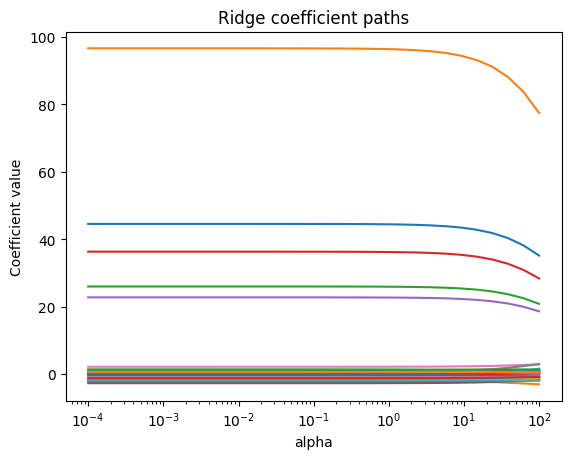

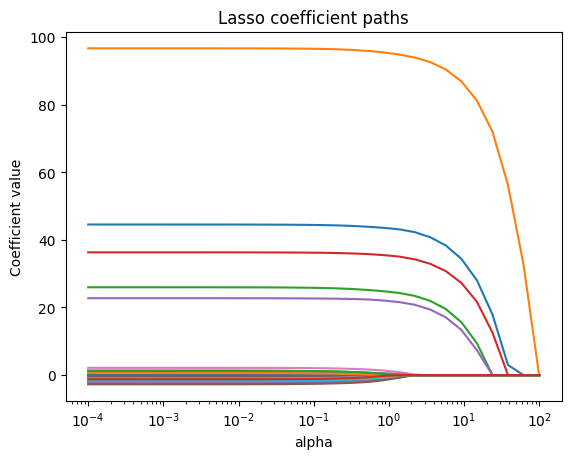

In [16]:
# Standardize once for path plotting
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# Track coefficients
coef_ridge = []
coef_lasso = []

for a in alphas:
    rr = Ridge(alpha=a, random_state=42)
    rr.fit(X_train_std, y_train)
    coef_ridge.append(rr.coef_)

    ll = Lasso(alpha=a, max_iter=10000, random_state=42)
    ll.fit(X_train_std, y_train)
    coef_lasso.append(ll.coef_)

import numpy as _np
coef_ridge = _np.array(coef_ridge)  # shape (len(alphas), d)
coef_lasso = _np.array(coef_lasso)

plt.figure()
for j in range(coef_ridge.shape[1]):
    plt.semilogx(alphas, coef_ridge[:, j])
plt.xlabel("alpha")
plt.ylabel("Coefficient value")
plt.title("Ridge coefficient paths")
plt.show()

plt.figure()
for j in range(coef_lasso.shape[1]):
    plt.semilogx(alphas, coef_lasso[:, j])
plt.xlabel("alpha")
plt.ylabel("Coefficient value")
plt.title("Lasso coefficient paths")
plt.show()

## 13) Compare models

We compare OLS vs. best Ridge/Lasso/EN on the test set and via cross-validation.

In [17]:
rows = []
rows.append(("OLS", rmse_ols, r2_ols, cv_ols))

ridge_cv = cv_rmse(ridge_best, X_train, y_train, cv=5)
lasso_cv = cv_rmse(lasso_best, X_train, y_train, cv=5)
en_cv    = cv_rmse(en_best,    X_train, y_train, cv=5)

rows.append(("Ridge", rmse_ridge, r2_ridge, ridge_cv))
rows.append(("Lasso", rmse_lasso, r2_lasso, lasso_cv))
rows.append(("ElasticNet", rmse_en, r2_en, en_cv))

summary_df = pd.DataFrame(rows, columns=["Model", "Test RMSE", "Test R^2", "CV RMSE"])
summary_df

,Model,Test RMSE,Test R^2,CV RMSE
0,OLS,26.181756,0.955043,26.466281
1,Ridge,26.131918,0.955214,26.423598
2,Lasso,25.347195,0.957864,24.925285
3,ElasticNet,25.347195,0.957864,24.925285


In [20]:
import pandas as pd
from IPython.display import display

print("📊 Regularization Summary (Test and CV):")
display(summary_df.style.set_caption("Regularization Summary (Test and CV)").format(precision=4))

📊 Regularization Summary (Test and CV):


,Model,Test RMSE,Test R^2,CV RMSE
0,OLS,26.1818,0.9550,26.4663
1,Ridge,26.1319,0.9552,26.4236
2,Lasso,25.3472,0.9579,24.9253
3,ElasticNet,25.3472,0.9579,24.9253


## 14) Residual diagnostics (quick look)

Just a simple scatter of residuals vs. predictions to see shrinkage effects qualitatively.

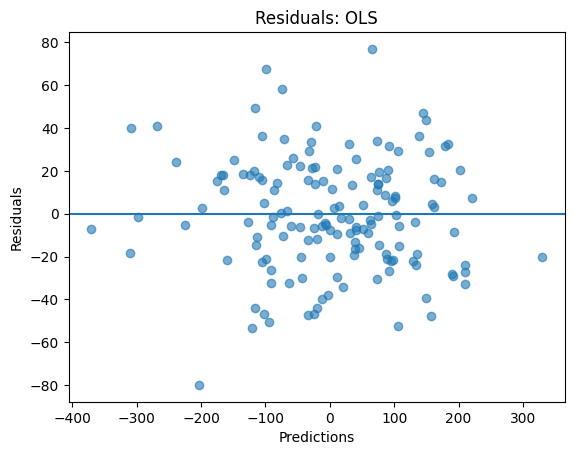

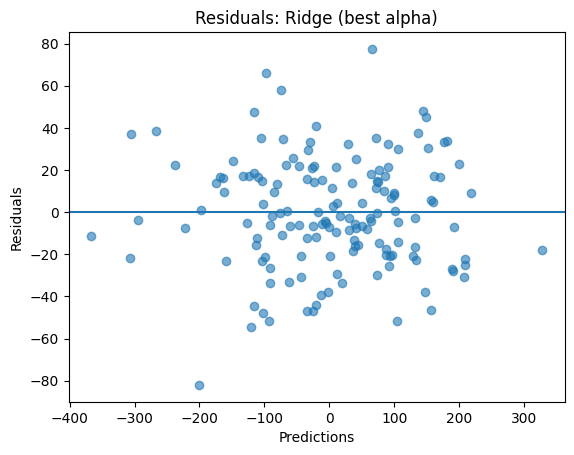

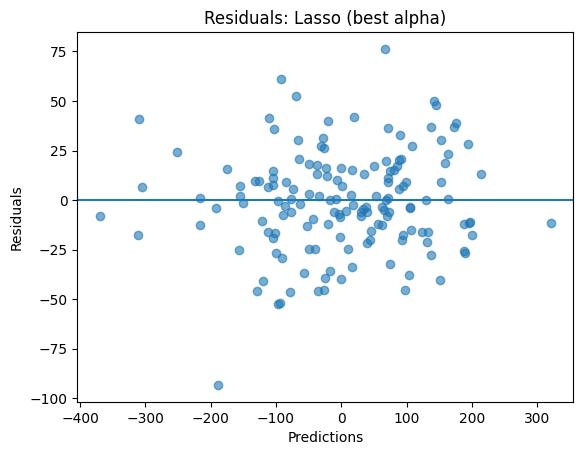

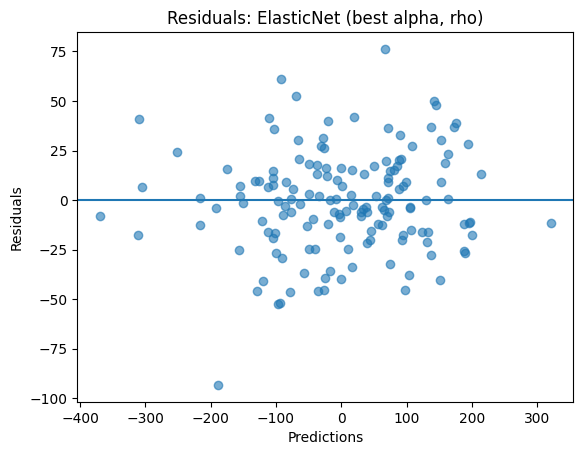

In [21]:
def plot_residuals(y_true, y_pred, title):
    res = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, res, alpha=0.6)
    plt.axhline(0.0)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

plot_residuals(y_test, y_pred_ols,   "Residuals: OLS")
plot_residuals(y_test, y_pred_ridge, "Residuals: Ridge (best alpha)")
plot_residuals(y_test, y_pred_lasso, "Residuals: Lasso (best alpha)")
plot_residuals(y_test, y_pred_en,    "Residuals: ElasticNet (best alpha, rho)")

## 15) Practical tips

- Always use a **pipeline** with scaling for Lasso/ElasticNet (and usually for Ridge too).
- Tune $\alpha$ (and $\rho$ for EN) with cross-validation; use a **log-spaced** grid for $\alpha$.
- Increase `max_iter` for Lasso/EN if you see convergence warnings.
- For high-dimensional data, consider **sparse solutions** (Lasso/EN) to help interpretability.
- When features are highly correlated, **Elastic Net** often performs more stably than pure Lasso.
- Evaluate with repeated CV if variance is high.

## 16) Bonus: Bayesian link & MAP intuition

Using Bayes’ theorem for parameters $\boldsymbol{\beta}$:

$$
P(\boldsymbol{\beta}\mid \mathbf{y}, X) = \frac{P(\mathbf{y}\mid X,\boldsymbol{\beta})\,P(\boldsymbol{\beta})}{P(\mathbf{y}\mid X)} \;\propto\; P(\mathbf{y}\mid X,\boldsymbol{\beta})\,P(\boldsymbol{\beta}).
$$

- With a Gaussian likelihood $P(\mathbf{y}\mid X,\boldsymbol{\beta})$ and a **Gaussian prior** on $\boldsymbol{\beta}$, the MAP estimate recovers **Ridge**.
- With a **Laplace prior**, the MAP estimate recovers **Lasso**.

As a reminder of syntax in notebooks:

$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)\,P(y)}{P(\mathbf{x})}
\;\propto\;
P(\mathbf{x}\mid y)\,P(y).
$$

And example inline math defining a class label $y \in \{1,\ldots,C\}$ and a feature vector $\mathbf{x} = (x_1,\ldots,x_d)$.